# Modeling

In [248]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [249]:
df_model = pd.read_csv('./Data/clean_data.csv', index_col=0)
df_model.head()

,amount_tsh,date_recorded,funder,gps_height,basin,region,local_government_area,population,permit,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity,source_type,waterpoint_type,status_group,construction_decade
0,6000.0,2011-03-14,Roman,1390,Lake Nyasa,Iringa,Ludewa,109,False,1999,gravity,user-group,annually,soft,enough,spring,communal standpipe,functional,1990s (1990-1999)
1,0.0,2013-03-06,Grumeti,1399,Lake Victoria,Mara,Serengeti,280,True,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2000s (2000-2009)
2,25.0,2013-02-25,Lottery Club,686,Pangani,Manyara,Simanjiro,250,True,2009,gravity,user-group,per bucket,soft,enough,dam,communal standpipe multiple,functional,2000s (2000-2009)
3,0.0,2013-01-28,Unicef,263,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,True,1986,submersible,user-group,never pay,soft,dry,borehole,communal standpipe multiple,non functional,1980s (1980-1989)
4,0.0,2011-07-13,Action In A,0,Lake Victoria,Kagera,Karagwe,0,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,Unknown


In [250]:
categorical_cols = ['region', 'extraction_type_class', 'management_group', 'funder',
                    'quantity', 'water_quality' , 'waterpoint_type', 'source_type', 'status_group' ]

In [251]:
numerical_cols = ['amount_tsh','gps_height', 'population']

In [252]:
df_model.drop(['date_recorded', 'construction_year', 'basin', 'local_government_area', 
                     'payment_type', 'permit', 'construction_decade'], axis=1, inplace=True)
#to be dropped before one hot encoding

In [253]:
# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Encode the categorical columns in the DataFrame
for col in categorical_cols:
    df_model[col] = encoder.fit_transform(df_model[col])

# covert categorical columns to integer
for col in categorical_cols:
    df_model[col] = df_model[col].astype(int)

In [254]:
#from category_encoders import OneHotEncoder
#ohe = OneHotEncoder(cols = categorical_cols)

In [255]:
#df_model = ohe.fit_transform(df_model)

In [256]:
df_model.head()

,amount_tsh,funder,gps_height,region,population,extraction_type_class,management_group,water_quality,quantity,source_type,waterpoint_type,status_group
0,6000.0,1319,1390,3,109,0,4,6,1,6,1,0
1,0.0,457,1399,9,280,0,4,6,2,3,1,0
2,25.0,803,686,8,250,0,4,6,1,1,2,0
3,0.0,1681,263,12,58,5,4,6,0,0,2,1
4,0.0,18,0,4,0,0,1,6,3,3,1,0


In [257]:
# split the dataset
X = df_model.drop('status_group', axis=1)
y = df_model['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [258]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56344 entries, 0 to 59399
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             56344 non-null  float64
 1   funder                 56344 non-null  int32  
 2   gps_height             56344 non-null  int64  
 3   region                 56344 non-null  int32  
 4   population             56344 non-null  int64  
 5   extraction_type_class  56344 non-null  int32  
 6   management_group       56344 non-null  int32  
 7   water_quality          56344 non-null  int32  
 8   quantity               56344 non-null  int32  
 9   source_type            56344 non-null  int32  
 10  waterpoint_type        56344 non-null  int32  
dtypes: float64(1), int32(8), int64(2)
memory usage: 3.4 MB


## Models

My data is now ready to be modeled. To begin, we will fit a dummy cllassifier model as my baseline model and analyze its performance indicators. Following that, I will fit several more classification models and evaluate their performance measures.

I will choose the two best-performing models from the four models based on accuracy. The remaining two models will subsequently be tuned with ensemble methods.


### 1. Dummy Classifier - Baseline model

> DummyClassifier makes predictions that ignore the input features. This classifier serves as a simple baseline to compare against other more complex classifiers.

- In terms of accuracy, the dummy classifier achieves an accuracy of 0.53, meaning that it correctly predicts the class for around 53% of the instances.

- Overall, these results indicate that the dummy classifier performs poorly in predicting class 1, as it never correctly identifies any instances of that class. It performs better in predicting class 0, achieving a reasonable precision and recall.

In [259]:
#Build a pipeline with a StandardScaler and a DummyClassifier
dummy_pipe = Pipeline([('scaler', StandardScaler()), 
                ('dummy', DummyClassifier(random_state=42))])
# fit the pipeline to the training set
dummy_pipe.fit(X_train, y_train)
# make predictions on the test set
y_pred_dummy = dummy_pipe.predict(X_test)
# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dummy))

Classification Report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.70      7534
           1       0.00      0.00      0.00      6552

    accuracy                           0.53     14086
   macro avg       0.27      0.50      0.35     14086
weighted avg       0.29      0.53      0.37     14086



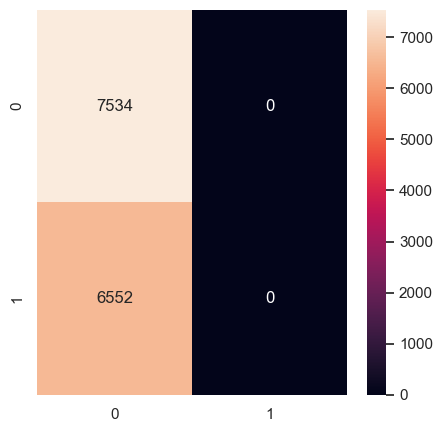

In [260]:
# Plot the confusion matrix without a color palette
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_dummy), annot=True, fmt='g')

# Show the plot
plt.show()

This is really low lets move to the next Classifier

### 2. Decision Tree Classifier

> Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. The intuition behind Decision Trees is that you use the dataset features to create yes/no questions and continually split the dataset until you isolate all data points belonging to each class.

In [261]:
# Create a pipeline with a decision tree classifier as the estimator:
dt = Pipeline([('scaler', StandardScaler()),
                  ('tree', DecisionTreeClassifier(random_state=42))])
# fit the pipeline to the training set
dt.fit(X_train, y_train)
# make predictions on the test set
y_pred_dt = dt.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      7534
           1       0.77      0.72      0.74      6552

    accuracy                           0.77     14086
   macro avg       0.77      0.77      0.77     14086
weighted avg       0.77      0.77      0.77     14086



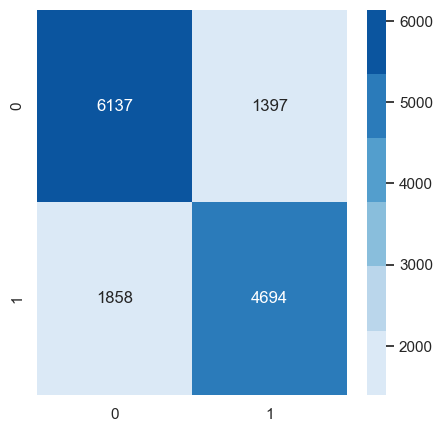

In [262]:
# Define a custom color palette
color_palette = sns.color_palette("Blues")
# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='g', cmap=color_palette);

- The accuracy score represents the proportion of correctly predicted instances out of the total number of instances. In this case, the decision tree model achieved an accuracy of around 0.75, indicating that it predicted 75% of instances correctly.

### 3. Decision Tree with GridsearchCV

In [264]:
dt = Pipeline([('scaler', StandardScaler()),
                  ('tree', DecisionTreeClassifier(random_state=42))])
# create a grid of parameters to test

param_grid = [{'tree__max_depth': [16, 18, 20],
              'tree__min_samples_split': [4, 6, 8],
              'tree__min_samples_leaf': [2, 3, 4],
              'tree__criterion': ['gini', 'entropy']}]

# create grid with estimators
gridsearch_dt = GridSearchCV(dt, param_grid, cv=5, n_jobs=-1, verbose=1)

# fit the grid with the data    
gridsearch_dt.fit(X_train, y_train);

# Get the best parameters
best_params_dt = gridsearch_dt.best_params_

print("Best Parameters:", best_params_dt)
# Make predictions on the test data using the trained pipeline
y_pred_gridsearchdt = gridsearch_dt.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_gridsearchdt))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 20, 'tree__min_samples_leaf': 4, 'tree__min_samples_split': 4}
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      7534
           1       0.80      0.69      0.74      6552

    accuracy                           0.78     14086
   macro avg       0.78      0.77      0.77     14086
weighted avg       0.78      0.78      0.78     14086



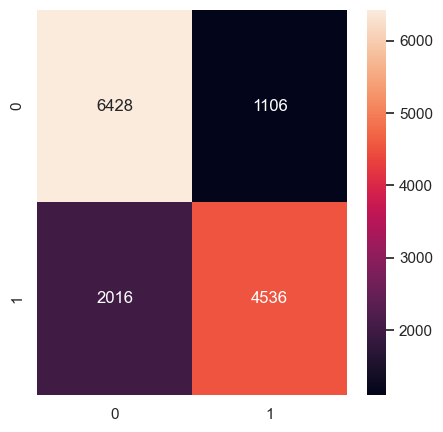

In [265]:
# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_gridsearchdt), annot=True, fmt='g');

#Logistic regression

In [263]:
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import classification_report

# Create a pipeline with a StandardScaler and a LogisticRegression classifier
#logreg_pipeline = Pipeline([
    #('scaler', StandardScaler()), 
    #('logreg', LogisticRegression(random_state=42))
])

# Fit the pipeline to the training set
logreg_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_pipeline.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))


SyntaxError: unmatched ']' (1742588137.py, line 8)

Thats really low for a second classifier. Logistic regression is suppossed to do the below;  

Logistic regression is a statistical model commonly used for binary classification tasks, where the goal is to predict one of two possible classes (e.g., 0 or 1, "yes" or "no").  

Logistic regression outputs probability scores for each class.   

 probabilities represent the likelihood that a given input belongs to a particular class. For a binary classification problem, logistic regression calculates the probability that an observation belongs to the positive class (typically labeled as 1).

Lets try to fing different ways to improve this model. Using this classifier, Simple models like Logistic Regression is easier to interpret compared to others.

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load your data into a DataFrame
df = pd.read_csv('./Data/clean_data.csv')  # Replace 'your_file.csv' with the actual file path

# Split your data into features and target variable
X = df.drop('status_group', axis=1)  # Replace 'status_group' with the name of your target variable
y = df['status_group']  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the preprocessing for numerical and categorical columns
numerical_cols = ['amount_tsh', 'gps_height', 'population']
categorical_cols = ['region', 'extraction_type_class', 'management_group', 'funder',
                    'quantity', 'water_quality', 'waterpoint_type', 'source_type']

# Define preprocessing for numerical data (imputation + scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data (imputation + one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the logistic regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the pipeline to the training data
logreg_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg_pipeline.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a colored heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=logreg_pipeline.classes_, yticklabels=logreg_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Engineering

In [ ]:
df.isnull().sum()

In [ ]:
len(df['amount_tsh']), len(df['gps_height'])


In [ ]:
print(df[['amount_tsh', 'gps_height']].head())


Create Interaction Features

Interaction features capture relationships between variables that might be missed if you only look at individual features. For instance, combining amount_tsh and gps_height could reveal insights into the relationship between these features.

In [ ]:
# Create an interaction feature
df['amount_tsh_gps_height'] = df['amount_tsh'] * df['gps_height']


Polynomial Features


Polynomial features are used to capture non-linear relationships. For numerical features, you can create polynomial terms (e.g., squared or cubic terms).

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Initialize PolynomialFeatures with degree 2 (squared terms)
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform the numerical features
X_numerical_poly = poly.fit_transform(df[numerical_cols])

# Create a DataFrame from the transformed features
df_numerical_poly = pd.DataFrame(X_numerical_poly, columns=poly.get_feature_names_out(numerical_cols))

# Concatenate the original DataFrame with the new polynomial features
df = pd.concat([df, df_numerical_poly], axis=1)


Binning

Binning involves converting continuous variables into categorical bins, which can help in managing outliers and capturing non-linear relationships

In [ ]:
# Check the structure of 'gps_height'
print(df['gps_height'].head())  # View the first few entries
print(df['gps_height'].apply(lambda x: type(x)).unique())  # Check the data types within the column


In [ ]:
# Check for duplicate indices
print(df.index[df.index.duplicated()].tolist())

# Check for duplicate columns
print(df.columns[df.columns.duplicated()].tolist())


In [ ]:
# Reset index to remove duplicates
df = df.reset_index(drop=True)


In [ ]:
# Remove duplicate columns, keeping the first occurrence
df = df.loc[:, ~df.columns.duplicated()]


In [ ]:
# Ensure 'gps_height' is numeric
df['gps_height'] = pd.to_numeric(df['gps_height'], errors='coerce')

# Define bins and labels
bins = [0, 500, 1000, 1500, 2000, 2500, 3000]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extreme']

# Apply binning
df['gps_height_binned'] = pd.cut(df['gps_height'], bins=bins, labels=labels)

# Verify the result
print(df[['gps_height', 'gps_height_binned']].head())


In [ ]:
# Check if 'gps_height' contains any non-numeric values
print(df['gps_height'].dtype)

# Verify 'gps_height_binned' values
print(df['gps_height_binned'].value_counts())


In [ ]:
# Example of a domain-specific feature
major_funders = ['Funder1', 'Funder2', 'Funder3']  # List of known major funders

# Create a binary feature indicating if the funder is a major funder
df['major_funder'] = df['funder'].apply(lambda x: 1 if x in major_funders else 0)


1. Amount TSH
Log Transformation:

In [ ]:
df['log_amount_tsh'] = np.log1p(df['amount_tsh'])


In [ ]:
bins_amount_tsh = [0, 1000, 5000, 10000, 50000, 100000]
labels_amount_tsh = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df['amount_tsh_binned'] = pd.cut(df['amount_tsh'], bins=bins_amount_tsh, labels=labels_amount_tsh)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['amount_tsh_standardized'] = scaler.fit_transform(df[['amount_tsh']])


GPS Height
Log Transformation:

In [ ]:
df['log_gps_height'] = np.log1p(df['gps_height'])


In [ ]:
bins_gps_height = [0, 500, 1000, 1500, 2000, 2500, 3000]
labels_gps_height = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extreme']
df['gps_height_binned'] = pd.cut(df['gps_height'], bins=bins_gps_height, labels=labels_gps_height)


In [ ]:
scaler = StandardScaler()
df['gps_height_standardized'] = scaler.fit_transform(df[['gps_height']])


3. Population Log Transformation

In [ ]:
df['log_population'] = np.log1p(df['population'])


In [ ]:
bins_population = [0, 500, 1000, 5000, 10000, 50000]
labels_population = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
df['population_binned'] = pd.cut(df['population'], bins=bins_population, labels=labels_population)


In [ ]:
scaler = StandardScaler()
df['population_standardized'] = scaler.fit_transform(df[['population']])


Interaction Features
1. Amount TSH and GPS Height Interaction

In [ ]:
df['amount_tsh_gps_height'] = df['amount_tsh'] * df['gps_height']


2.Amount TSH and Population Interaction:

In [ ]:
df['amount_tsh_population'] = df['amount_tsh'] * df['population']


3.GPS Height and Population Interaction:

In [ ]:
df['gps_height_population'] = df['gps_height'] * df['population']
